<a href="https://colab.research.google.com/github/RaghulRajM/Data-Science-Advanced-Scalathon---Bi2i/blob/main/DS_Advanced_Hackathon_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## XYZ is an American bookseller. It is a Fortune 1000 company and the bookseller with the largest number of retail outlets in the United States. It also sells books through various ecommerce channels. They sell around 3684 unique books in their different stores among which there are  4 top selling books on the basis of customer reviews. So XYZ has approached Bridgei2i Analytics Solutions to help them plan their growth strategy.

### Importing the libraries

In [ ]:
import pandas as pd
import nltk
from textblob import TextBlob
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn import tree
from sklearn.tree import export_text
import graphviz
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.model_selection import train_test_split
import pmdarima as pm

### 1. XYZ wants to understand which books have most positive reviews among the whole set (They are expecting ranking for the top 4 books)

In [ ]:
reviews=pd.read_excel('Reviews.xlsx')

In [ ]:
reviews.head()

,Comment,BookCode
0,"This is a self-published book, and if you want...",52979
1,I was a dissapointed to see errors on the back...,22722
2,A complete waste of time. Typographical errors...,52720
3,I feel I have to write to keep others from was...,32722
4,Excellent stockings for long shifts on your fe...,84987


In [ ]:
reviews['Comment'][0]

'This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon\'s family and friends--or perhaps, by herself! I can\'t imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a "worst book" contest. I can\'t believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on "To Kill a Mockingbird"--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone as a joke---stay far, far away from this one!'

#### Lemmatised  and tokenised only words

In [ ]:
lemmatizer = WordNetLemmatizer()
reviews['Comment'] = reviews['Comment'].apply(lambda y:  ' '.join([(lemmatizer.lemmatize(i)) for i in y.split(" ")]) if type(y)==str else y)

In [ ]:
reviews['Comment'][0]

'This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star review must have been written by Ms. Haddon\'s family and friends--or perhaps, by herself! I can\'t imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysteric reading bit and piece of it to one another. It is most definitely bad enough to be entered into some kind of a "worst book" contest. I can\'t believe Amazon even sell this kind of thing. Maybe I can offer them my 8th grade term paper on "To Kill a Mockingbird"--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone a a joke---stay far, far away from this one!'

#### Sentiment analysis using textblob

In [ ]:
nltk_tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
def split(text):
    sentences = text.split('. ')
    tokenized_sentences = [nltk_tokenizer.tokenize(sent) for sent in sentences]
    return tokenized_sentences


def textblob(sentences):
    for sentence in split(sentences):
        sentence = " ".join([ch for ch in sentence ])

        if sentence=='':
            return 0
        else:
            return TextBlob(sentence).sentiment[0]

scores=[textblob(i) if type(i)==str else 0 for i in reviews['Comment'] ]
reviews['scores']=scores
reviews['scores'] = [1 if(i>0) else 0 for i in reviews['scores']]
df=pd.DataFrame(reviews.groupby(['BookCode'])['scores'].sum())
df.reset_index(inplace=True)
df.sort_values(['scores'],ascending=False)

,BookCode,scores
2,22979,8316
15,84987,8309
1,22722,8279
0,22720,8245
11,52979,2186
19,124987,2183
3,32720,2169
4,32722,2158
9,52720,2113
7,42722,2098


In [ ]:
new_df=reviews['BookCode'].value_counts().reset_index()
new_df.columns=['BookCode','Count']
new_df

,BookCode,Count
0,84987,11819
1,22722,11802
2,22979,11706
3,22720,11683
4,52979,4258
5,32720,4254
6,124987,4202
7,94987,4187
8,32722,4156
9,62722,4101


#### We calculate the normalised score by divinding the score of each book by the count of reviews for that book, to get a normalised score.

In [ ]:
merge_df=df.merge(new_df,on=['BookCode'])
merge_df['normalised_score']=merge_df['scores']/merge_df['Count']
merge_df=merge_df.sort_values(['normalised_score'],ascending=False)
merge_df

,BookCode,scores,Count,normalised_score
2,22979,8316,11706,0.710405
0,22720,8245,11683,0.705726
15,84987,8309,11819,0.703021
1,22722,8279,11802,0.701491
12,62720,2090,4007,0.521587
19,124987,2183,4202,0.519515
4,32722,2158,4156,0.519249
9,52720,2113,4076,0.518400
5,32979,2085,4027,0.517755
7,42722,2098,4059,0.516876


In [ ]:
books=merge_df['BookCode'][:4]
top4books=pd.DataFrame(columns=['Top 4 BookCode'])
top4books['Top 4 BookCode']=books
top4books

,Top 4 BookCode
2,22979
0,22720
15,84987
1,22722


#### Note: We observed that the top four books with the most positive reviews had the following bookcodes: '84987','22979','22720' and '22722'

### 2. XYZ bookseller wants to plan demand for the top shelf books for the upcoming 2 months across all the 21 states (given in data) of US

In [ ]:
sales_train=pd.read_excel('Sales.xlsx',sheet_name='Train')
sales_test=pd.read_excel('Sales.xlsx',sheet_name='Test')

In [ ]:
sales_train.head(3)

,Units Sold,Available Books in the shelf,Price,State,Time,Week,NewYear,MLK,Presidents,GoodFriday,Memorial,Independence,Labor,Thanksgiving,Christmas,BookCode,isHoliday
0,6187.0,10146.68,14.474543,Arizona,Week End 01-06-19,2019-01-06,1,0,0,0,0,0,0,0,0,22722,1
1,9123.0,15144.18,14.174504,Arizona,Week End 01-07-18,2018-01-07,1,0,0,0,0,0,0,0,0,22722,1
2,6236.0,8356.24,14.150096,Arizona,Week End 01-13-19,2019-01-13,0,0,0,0,0,0,0,0,0,22722,0


In [ ]:
sales_test.head(3)

,Available Books in the shelf,Price,State,Time,Week,NewYear,MLK,Presidents,GoodFriday,Memorial,Independence,Labor,Thanksgiving,Christmas,BookCode,isHoliday
0,5123.0,14.106784,Arizona,Week End 11-03-19,2019-11-03,0,0,0,0,0,0,0,0,0,22722,0
1,10064.0,13.935992,Arizona,Week End 11-10-19,2019-11-10,0,0,0,0,0,0,0,0,0,22722,0
2,8299.0,13.792752,Arizona,Week End 11-17-19,2019-11-17,0,0,0,0,0,0,0,0,0,22722,0


In [ ]:
#Filtering for the books
books=['84987','22979','22720','22722']
sales_temp_train=sales_train[sales_train['BookCode'].isin(books)]
sales_temp_test=sales_test[sales_test['BookCode'].isin(books)]

In [ ]:
#Filtering for one combo of the book code and state to run model
sales_temp1_train=sales_temp_train[(sales_temp_train['State']=='Arizona') &(sales_temp_train['BookCode']==22722)]
sales_temp1_train.sort_values(['Week'],inplace=True)

sales_temp1_test=sales_temp_test[(sales_temp_test['State']=='Arizona') &(sales_temp_test['BookCode']==22722)]
sales_temp1_test.sort_values(['Week'],inplace=True)

C:\Users\raghulraj.m\AppData\Local\Continuum\anaconda3\envs\csk\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\raghulraj.m\AppData\Local\Continuum\anaconda3\envs\csk\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


#### Stationary Test - Dickey Fuller

We compared the ‘Test Statistic’ and the ‘Critical Value’ to check for the stationarity of the time series

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,week):

    #Determing rolling statistics
    rolmean = timeseries.rolling( window=12).mean()
    rolstd = timeseries.rolling( window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(week,timeseries, color='blue',label='Original')
    mean = plt.plot(week,rolmean, color='red', label='Rolling Mean')
    std = plt.plot(week,rolstd, color='black', label = 'Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


C:\Users\raghulraj.m\AppData\Local\Continuum\anaconda3\envs\csk\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


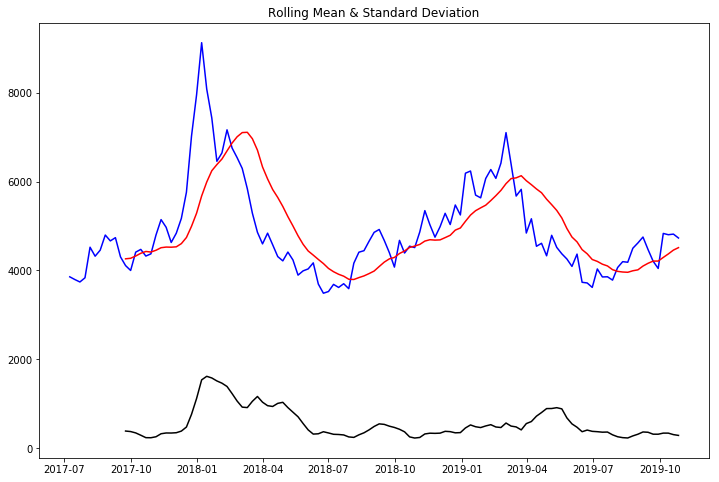

Results of Dickey-Fuller Test:
Test Statistic                  -3.433703
p-value                          0.009862
#Lags Used                      13.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In [ ]:
test_stationarity(sales_temp1_train['Units Sold'],sales_temp1_train['Week'])

#### Seasonal decompose

We leveraged the Seasonal Decompose package to inspect the time series components such as Trend, Seasonality and Residuals

C:\Users\raghulraj.m\AppData\Local\Continuum\anaconda3\envs\csk\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

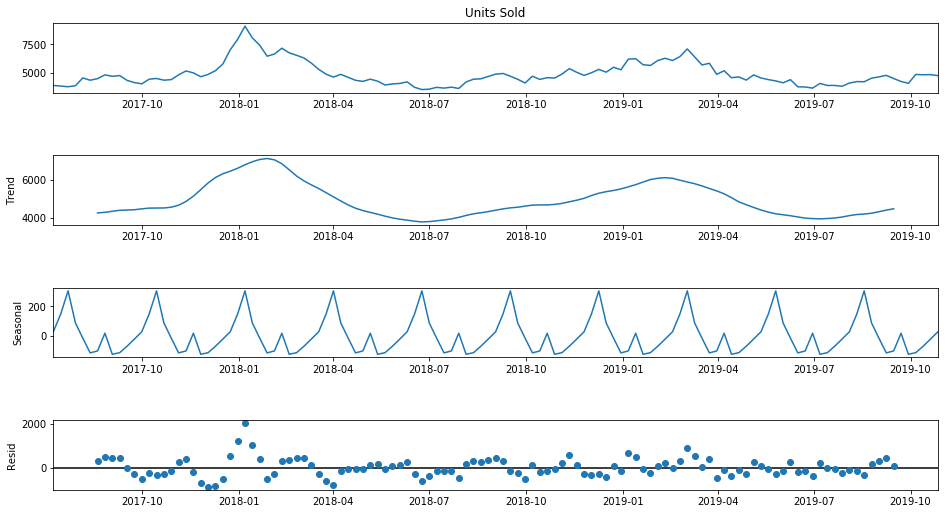

In [ ]:
sales_temp1_train.index=sales_temp1_train['Week']

decomposition = seasonal_decompose(sales_temp1_train['Units Sold'], freq=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)


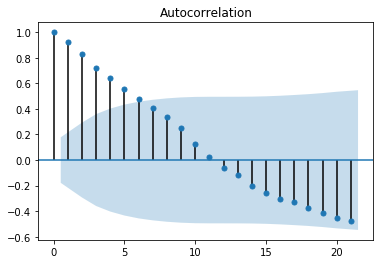

In [ ]:
#ACF plots
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(sales_temp1_train['Units Sold'])
plt.show()

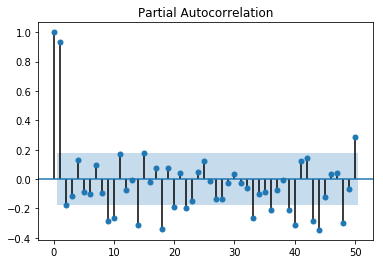

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(sales_temp1_train['Units Sold'], lags=50)
plt.show()

In [ ]:
mod = SARIMAX(endog=sales_temp1_train['Units Sold'],exog=sales_temp1_train[sales_temp1_train.columns.difference(['Units Sold','Time','Week','State','diff'])], order=(0,1,0))
res = mod.fit(disp=False)
print(res.summary())

C:\Users\raghulraj.m\AppData\Local\Continuum\anaconda3\envs\csk\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
C:\Users\raghulraj.m\AppData\Local\Continuum\anaconda3\envs\csk\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:             Units Sold   No. Observations:                  121
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -869.861
Date:                Tue, 16 Mar 2021   AIC                           1765.721
Time:                        17:22:03   BIC                           1801.959
Sample:                    07-09-2017   HQIC                          1780.437
                         - 10-27-2019                                         
Covariance Type:                  opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Available Books in the shelf     0.0425      0.029      1.462      0.144      -0.014       0.100
BookCode                     -6.742e-10        nan        nan        nan     

### Automating the Whole process-Using pmdarima which automatically detects the order(AR,MA coefficients) and the seasonality order if present

#### Running for the train test split to check the performance of our model by validating with AIC and BIC scores. Filtering for individual bookcodes and states and running with all possible combinations of exogenous variables ('Available Books in the shelf', 'Price' and 'isHoliday') and without any exogenous variable

In [ ]:
import warnings
import itertools
warnings.filterwarnings('ignore')
def train_test_split_fit(data,bookcode,states):
    mock=data.copy()
    for i in bookcode:
        for j in states:
            mock=data[(data['State']==j) &(data['BookCode']==i)]
            if len(mock)==0:
                continue
            print(f'Running for State:{j} and Bookcode:{i}')
            # Load/split your data
            y = mock['Units Sold'].reset_index(drop=True)
            train, test = train_test_split(y, train_size=0.8)
            for cols in list(itertools.chain(*map(lambda x: itertools.combinations(
                ['Available Books in the shelf', 'Price', 'isHoliday'], x), range(0, 4)))):
                if not cols:
                    print('Without exogenous')
                    # Fit model
                    model = pm.auto_arima(train, seasonal=True, m=52)

                    # make forecasts
                    forecasts = model.predict(test.shape[0])  # predict N steps into the future

                else:
                    print(f'With exogenous columns {cols}')

                    # Fit model
                    model = pm.auto_arima(train, seasonal=True, m=52, exogenous=sales_temp1_train[list(cols)].reset_index(drop=True)[:len(train)])

                    # make forecasts
                    forecasts = model.predict(test.shape[0],exogenous=sales_temp1_train[list(cols)].reset_index(drop=True)[len(train):])  # predict N steps into the future
                print(f'AIC:{model.aic()},BIC:{model.bic()}')

In [ ]:
train_test_split_fit(sales_train,books,sales_train.State.unique())

#### From the above step we observed that the AIC and BIC values were minimal for models considering exogenous variable as 'isHoliday',

In [ ]:
def prediction(train_data, test_data, bookcode, states):
    mock_train=train_data.copy()
    mock_test=test_data.copy()
    for i in bookcode:
        for j in states:
            mock_train=train_data[(train_data['State']==j) &(train_data['BookCode']==i)]
            mock_test=test_data[(test_data['State']==j) &(test_data['BookCode']==i)]
            if len(mock_test)==0:
                continue

            # Fit the model
            model = pm.auto_arima(mock_train['Units Sold'], seasonal=True, m=52, exogenous=mock_train[['isHoliday']].reset_index(drop=True))

            # make forecasts
            forecasts = model.predict(mock_test.shape[0],exogenous=mock_test[['isHoliday']].reset_index(drop=True))  # predict N steps into the future
            test_data.loc[(test_data['State']==j) &(test_data['BookCode']==i),'Units Sold']=forecasts
    return (test_data)


In [ ]:
out=predict(sales_train,sales_test,books,sales_train.State.unique())

In [ ]:
out[['State','Week','BookCode','Units Sold']].to_csv('Output.csv',index=False)

### 3. XYZ also wants Bridgei2i to determine the profile of customers who have given the most positive reviews

In [ ]:
customer_data = pd.read_excel("Customer_v2.xlsx")

In [ ]:
customer_data.head()

,CustomerID,BookCode,Age
0,17850,32722,19
1,17850,32979,19
2,17850,94987,19
3,17850,32720,19
4,17850,42722,19


In [ ]:
customer_data["Age"].describe()

count    1461.000000
mean       46.566735
std         8.915230
min        11.000000
25%        40.000000
50%        47.000000
75%        54.000000
max        81.000000
Name: Age, dtype: float64

In [ ]:
customer_data["Age"].isnull().sum()

0

#### Filtering for top 4 book codes

In [ ]:
book_codes=['84987','22979','22720','22722']

In [ ]:
customer_data = customer_data[customer_data["BookCode"].isin(book_codes)]

#### Initial analysis on data

In [ ]:
customer_data.groupby("BookCode")["Age"].mean()

BookCode
22720    46.589062
22722    46.463104
22979    46.293333
84987    47.000000
Name: Age, dtype: float64

In [ ]:
customer_data.groupby("BookCode")["Age"].median()

BookCode
22720    47
22722    47
22979    47
84987    48
Name: Age, dtype: int64

(array([  2.,  30.,  20., 219., 394., 366., 368.,  57.,   0.,   5.]),
 array([11., 18., 25., 32., 39., 46., 53., 60., 67., 74., 81.]),
 <BarContainer object of 10 artists>)

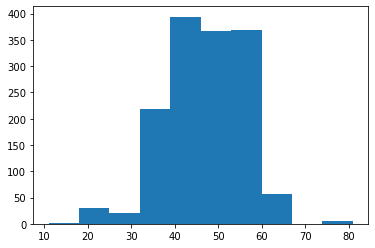

In [ ]:
plt.hist(customer_data['Age'])

#### Trying out Decision Tree for getting age bins for each BookCode

In [ ]:
clf = DecisionTreeClassifier(class_weight='balanced')
clf = clf.fit(pd.DataFrame(customer_data['Age']), customer_data['BookCode'])

In [ ]:
r = export_text(clf)
print(r)

|--- feature_0 <= 48.50
|   |--- feature_0 <= 43.50
|   |   |--- feature_0 <= 32.00
|   |   |   |--- feature_0 <= 18.50
|   |   |   |   |--- feature_0 <= 14.50
|   |   |   |   |   |--- class: 22722
|   |   |   |   |--- feature_0 >  14.50
|   |   |   |   |   |--- class: 22979
|   |   |   |--- feature_0 >  18.50
|   |   |   |   |--- feature_0 <= 28.50
|   |   |   |   |   |--- feature_0 <= 20.50
|   |   |   |   |   |   |--- feature_0 <= 19.50
|   |   |   |   |   |   |   |--- class: 22722
|   |   |   |   |   |   |--- feature_0 >  19.50
|   |   |   |   |   |   |   |--- class: 22722
|   |   |   |   |   |--- feature_0 >  20.50
|   |   |   |   |   |   |--- feature_0 <= 23.50
|   |   |   |   |   |   |   |--- feature_0 <= 22.50
|   |   |   |   |   |   |   |   |--- feature_0 <= 21.50
|   |   |   |   |   |   |   |   |   |--- class: 84987
|   |   |   |   |   |   |   |   |--- feature_0 >  21.50
|   |   |   |   |   |   |   |   |   |--- class: 22720
|   |   |   |   |   |   |   |--- feature_0 >  22.50


Since there was only one feature, decision tree didn't yield proper results. Hence, we're going ahead with creating bins manually wrt the distribution of data.

#### Manual Binning

In [ ]:
customer_data["Decile_binning"] = pd.cut(customer_data["Age"],10)

In [ ]:
for book_code in book_codes:
    temp_data = customer_data[customer_data["BookCode"]==book_code]
    print("BOOK CODE:",book_code)
    print(temp_data.groupby(["Decile_binning"])["BookCode"].count())

BOOK CODE: 84987
Decile_binning
(10.93, 18.0]     0
(18.0, 25.0]      4
(25.0, 32.0]      2
(32.0, 39.0]     38
(39.0, 46.0]     50
(46.0, 53.0]     51
(53.0, 60.0]     58
(60.0, 67.0]      0
(67.0, 74.0]      0
(74.0, 81.0]      0
Name: BookCode, dtype: int64
BOOK CODE: 22979
Decile_binning
(10.93, 18.0]     2
(18.0, 25.0]      1
(25.0, 32.0]      2
(32.0, 39.0]     51
(39.0, 46.0]     56
(46.0, 53.0]     53
(53.0, 60.0]     59
(60.0, 67.0]      0
(67.0, 74.0]      0
(74.0, 81.0]      1
Name: BookCode, dtype: int64
BOOK CODE: 22720
Decile_binning
(10.93, 18.0]      3
(18.0, 25.0]      13
(25.0, 32.0]       8
(32.0, 39.0]     119
(39.0, 46.0]     174
(46.0, 53.0]     159
(53.0, 60.0]     161
(60.0, 67.0]       1
(67.0, 74.0]       0
(74.0, 81.0]       2
Name: BookCode, dtype: int64
BOOK CODE: 22722
Decile_binning
(10.93, 18.0]      4
(18.0, 25.0]       8
(25.0, 32.0]       5
(32.0, 39.0]      70
(39.0, 46.0]     103
(46.0, 53.0]     100
(53.0, 60.0]     100
(60.0, 67.0]       1
(67.0, 

#### Using 3 Bins

In [ ]:
customer_data["Three_cut_binning"] = pd.cut(customer_data["Age"],3)

In [ ]:
for book_code in book_codes:
    temp_data = customer_data[customer_data["BookCode"]==book_code]
    print("BOOK CODE:",book_code)
    print(temp_data.groupby(["Three_cut_binning"])["BookCode"].count())
#     print(temp_data["Age"].describe())

BOOK CODE: 84987
Three_cut_binning
(10.93, 34.333]       6
(34.333, 57.667]    170
(57.667, 81.0]       27
Name: BookCode, dtype: int64
BOOK CODE: 22979
Three_cut_binning
(10.93, 34.333]       5
(34.333, 57.667]    195
(57.667, 81.0]       25
Name: BookCode, dtype: int64
BOOK CODE: 22720
Three_cut_binning
(10.93, 34.333]      24
(34.333, 57.667]    543
(57.667, 81.0]       73
Name: BookCode, dtype: int64
BOOK CODE: 22722
Three_cut_binning
(10.93, 34.333]      17
(34.333, 57.667]    337
(57.667, 81.0]       39
Name: BookCode, dtype: int64


In [ ]:
most_customers_bin = customer_data[(customer_data["Age"]>34.333)&(customer_data["Age"]<=57.667)]

In [ ]:
for book_code in book_codes:
    temp_data = most_customers_bin[most_customers_bin["BookCode"]==book_code]
    temp_data["Sub_category_bin"] = pd.cut(temp_data["Age"],3)
    print("BOOK CODE:",book_code)
    book_code_value_count = pd.DataFrame(temp_data["BookCode"].value_counts())
    print(temp_data.groupby(["Sub_category_bin"])["BookCode"].count()/temp_data["CustomerID"].nunique())
#     print(temp_data["Age"].describe())

BOOK CODE: 84987
Sub_category_bin
(34.978, 42.333]    0.382353
(42.333, 49.667]    0.252941
(49.667, 57.0]      0.364706
Name: BookCode, dtype: float64
BOOK CODE: 22979
Sub_category_bin
(34.978, 42.333]    0.394872
(42.333, 49.667]    0.307692
(49.667, 57.0]      0.297436
Name: BookCode, dtype: float64
BOOK CODE: 22720
Sub_category_bin
(34.978, 42.333]    0.351750
(42.333, 49.667]    0.307551
(49.667, 57.0]      0.340700
Name: BookCode, dtype: float64
BOOK CODE: 22722
Sub_category_bin
(34.978, 42.333]    0.332344
(42.333, 49.667]    0.323442
(49.667, 57.0]      0.344214
Name: BookCode, dtype: float64


/home/ishwarya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
